In [17]:
from imutils import face_utils

In [6]:
import numpy as np
import imutils
import argparse
import dlib
import cv2
import random
from PIL import Image

In [19]:
# import the necessary packages
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import argparse
import imutils
import dlib
import cv2

import matplotlib.pyplot as plt

# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--shape-predictor", required=True,help="path to facial landmark predictor")
#%tb ap.add_argument("-i", "--image", required=True,help="path to input image")
#%tb args = vars(ap.parse_args())



In [20]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=256)

In [9]:
%matplotlib inline

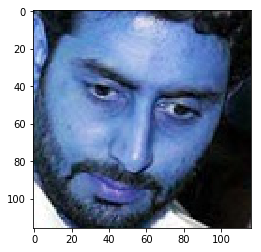

In [24]:
# Face Align Function
def faceAlign(image):
    #image = cv2.imread(img)
    image = imutils.resize(image, width=800)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 2)
    faceAligned = []
    for rect in rects:
        faceAligned = fa.align(image, gray, rect)
        #print(rect)
        #plt.imshow(faceAligned)
    
    return faceAligned


image = cv2.imread('dataset_cropped/Abhishek Bachan/AbhishekBachan71.jpg')
plt.imshow(image)
#plt.imshow(faceAlign(image))

In [25]:
import os                                                                                                             

def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r  

image_paths=list_files('dataset_cropped')
#print(image_paths)

In [27]:
# Finding unique labesl and encoding them

all_labels = [imag.split('/')[-2] for imag in image_paths]

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(all_labels)
labels_enc = le.transform(all_labels)

In [28]:
unique_labels = list(le.classes_)
print(unique_labels)
print(le.transform(unique_labels))

['Abhishek Bachan', 'Alex Rodriguez', 'Ali Landry', 'Alyssa Milano', 'Anderson Cooper', 'Anna Paquin', 'Audrey Tautou', 'Barack Obama', 'Ben Stiller', 'Christina Ricci', 'Clive Owen', 'Cristiano Ronaldo', 'Daniel Craig', 'Danny Devito', 'David Duchovny', 'Denise Richards', 'Diane Sawyer']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [33]:
from tqdm import tqdm

def read_images(image_paths):
    images = [];
    labels = [];
    for img_path in image_paths:
        image = faceAlign(cv2.imread(img_path));
        if image is not None:
            images.append(image)
            labels.append(img_path.split('/')[1])
    return images,labels

In [34]:
## Encoding labels


#list(le.classes_)

def data_gen(batch_size=30):
    while True:
        image_paths=list_files('dataset_cropped')
        sample_dt=random.sample(image_paths,int(batch_size))
        
        images,labels=read_images(sample_dt)
        #images,measurements=random_append_augment_images(images,measurements)
        
        images=np.asarray(images)
        labels=np.asarray(labels)
        #print('images shape',images.shape)
        #print('measurements shape',measurements.shape)
        ind = np.random.choice(images.shape[0], int(batch_size), replace=False)
        images=images[ind,:,:,:]
        labels=le.transform(labels[ind])
        X=images
        y=labels
        
        yield X,y

In [35]:
sample_length = 15
image_paths=list_files('dataset_cropped')
sample_dt=random.sample(image_paths,int(sample_length))
images,labels=read_images(sample_dt)

(15,)


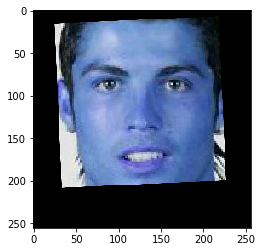

In [36]:

print(np.shape(images))
plt.imshow(images[10])


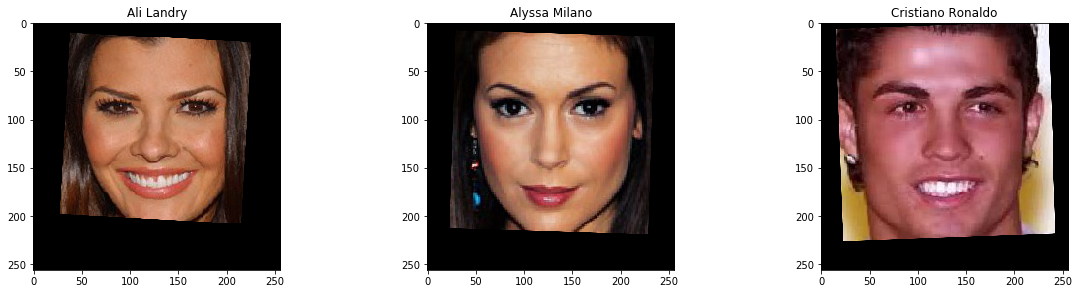

In [37]:
## Diplay sample 3 image with label

img_idx1, img_idx2, img_idx3 = random.sample(list(range(0,sample_length-1)),3)

fig = plt.figure(figsize=[20,10])
plt.subplot(231)
plt.title(labels[img_idx1])
plt.imshow(cv2.cvtColor(images[img_idx1], cv2.COLOR_BGR2RGB))

plt.subplot(232)
plt.title(labels[img_idx2])
plt.imshow(cv2.cvtColor(images[img_idx2], cv2.COLOR_BGR2RGB))

plt.subplot(233)
plt.title(labels[img_idx3])
plt.imshow(cv2.cvtColor(images[img_idx3], cv2.COLOR_BGR2RGB))


image = images[img_idx1]

['Abhishek Bachan', 'Alex Rodriguez', 'Ali Landry', 'Alyssa Milano', 'Anderson Cooper', 'Anna Paquin', 'Audrey Tautou', 'Barack Obama', 'Ben Stiller', 'Christina Ricci', 'Clive Owen', 'Cristiano Ronaldo', 'Daniel Craig', 'Danny Devito', 'David Duchovny', 'Denise Richards', 'Diane Sawyer']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [38]:
# Alexnet

from keras.models import Sequential
from keras.layers import Flatten,Dense, Lambda
# There was a problem with original Keras progress bar due to which Notebook used to hang.
# Changing the progress bar with another version of it so as to get the code working in Notebook. Look at model.fit command on how its used
#from keras_tqdm import TQDMNotebookCallback 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Activation, Cropping2D, ELU
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

input_shape=(image.shape[0],image.shape[1],3)
model=Sequential()
model.add(Lambda(lambda x:x/255.0-0.50,input_shape=input_shape))
model.add(Conv2D(3,1,1,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(24,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(36,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Dropout(.4))
model.add(Conv2D(48,5,5,subsample=(2,2),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(64,3,3,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(ELU())
model.add(Conv2D(64,3,3,subsample=(1,1),border_mode="valid",init='he_normal'))
model.add(Dropout(.3))
model.add(ELU())
model.add(Flatten())
model.add(Dense(1164,init='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(.2))
model.add(Dense(100,init='he_normal'))
model.add(ELU())
model.add(Dense(50,init='he_normal'))
model.add(ELU())
model.add(Dense(10,init='he_normal'))
model.add(ELU())
model.add(Dense(1,init='he_normal'))

model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

batch_size=30
epochs=4
gen_train=data_gen(30)
gen_valid=data_gen(30)


Using TensorFlow backend.


In [39]:
model.fit_generator(gen_train, samples_per_epoch=25000,nb_epoch=epochs,validation_data=gen_valid,nb_val_samples=2500, max_q_size=25, nb_worker=4, pickle_safe=True)

Epoch 1/4


KeyboardInterrupt: 